In [ ]:
!pip install scikit-learn pandas matplotlib seaborn

In [ ]:
import pandas as pd

# Upload the file manually in Colab: click folder > upload
df = pd.read_csv('/content/energydata_complete.csv')

# Preview
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
import numpy as np

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Drop duplicates
df.drop_duplicates(inplace=True)

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Extract useful time features
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Drop original date column
df.drop(columns=['date'], inplace=True)

# Check datatypes and shape
print(df.dtypes)
print("Dataset shape after cleaning:", df.shape)


Missing values:
 date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          fl

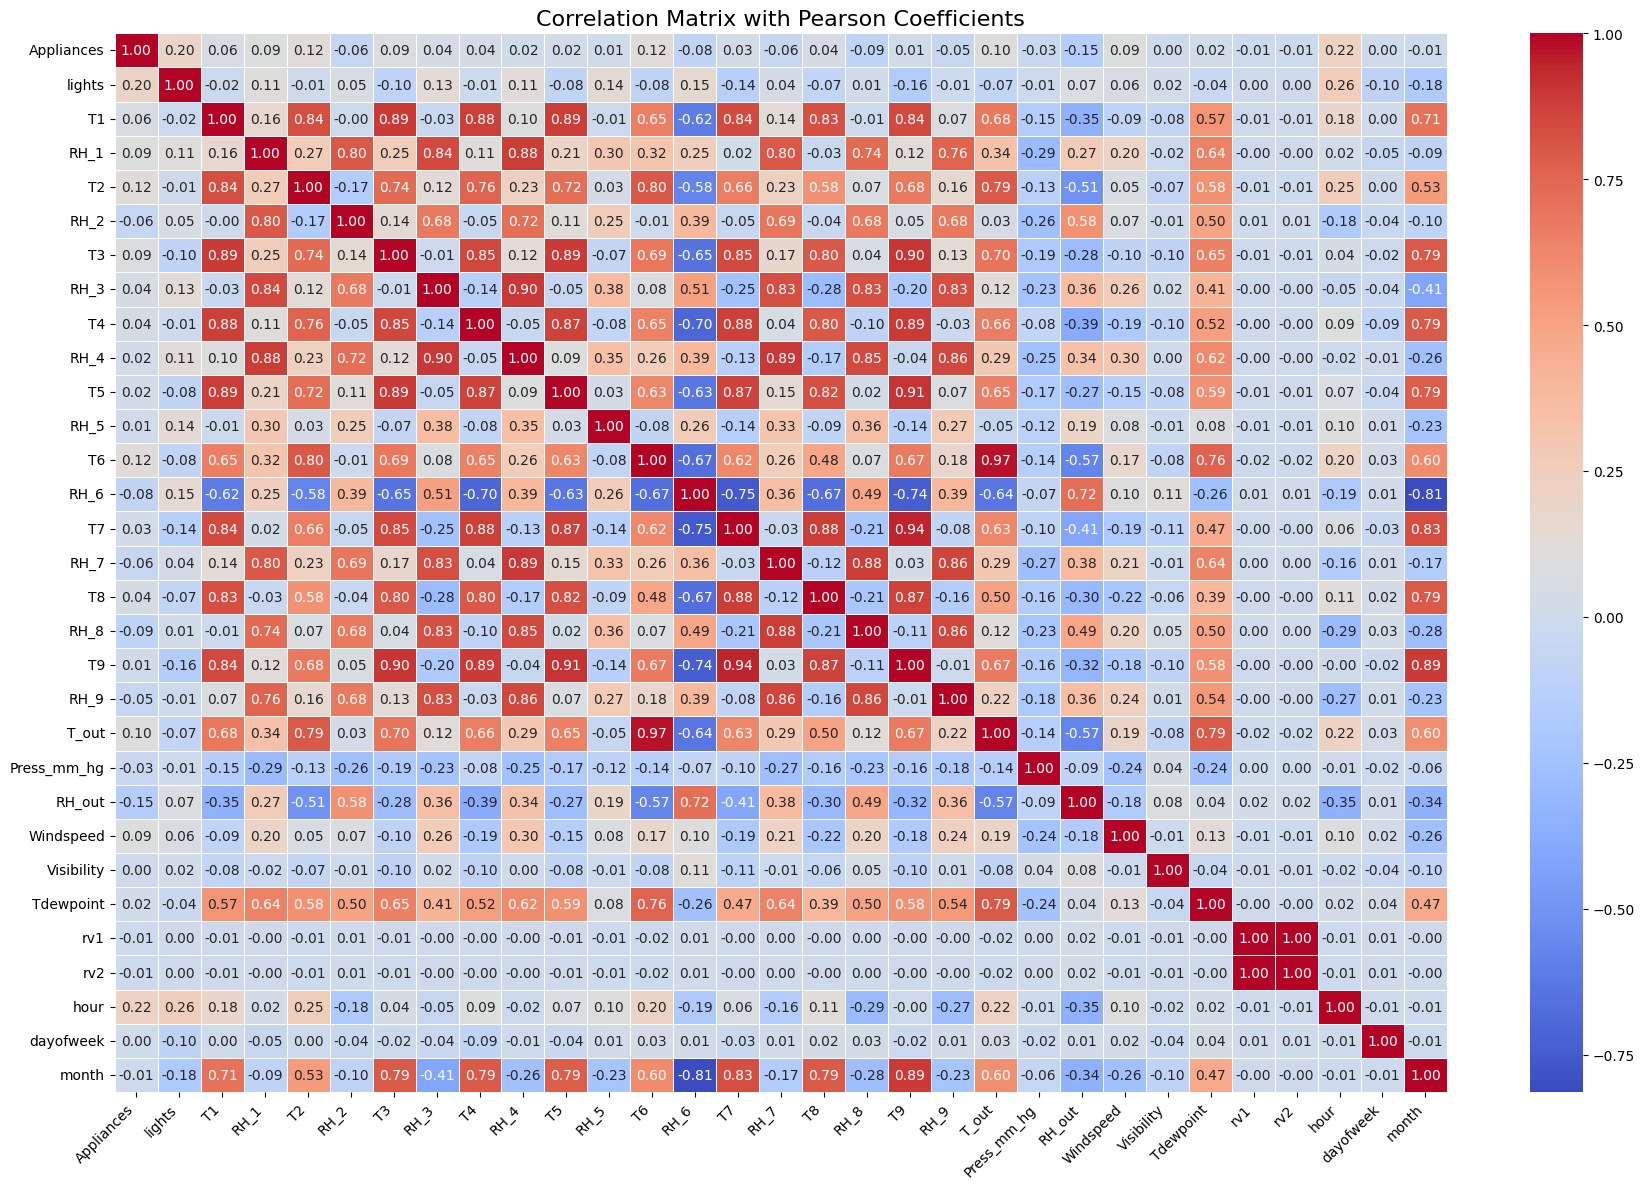

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(18, 12))

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap with annotations
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with Pearson Coefficients", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Outlier removal using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Define inputs & targets
X = df.drop(columns=['Appliances'])
y = df['Appliances']

# Standardize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df.drop(columns=to_drop, inplace=True)

print("Dropped due to high collinearity:", to_drop)

Dropped due to high collinearity: ['T_out', 'rv2']


In [ ]:
df['Appliances'] = y  # temporarily put it back for correlation
top_features = df.corr()['Appliances'].abs().sort_values(ascending=False).index[1:16]
X = df[top_features]
y = df['Appliances']
df.drop(columns=['Appliances'], inplace=True)  # clean up

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build and train GPR model
kernel = Matern()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
gpr.fit(X_train, y_train)

# Predict and evaluate
y_pred = gpr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
r2_median = r2_score(y_test, np.median(y_pred) * np.ones_like(y_test))

print(f"✅ Mean Absolute Error (MAE): {mae:.3f}")
print(f"✅ Mean Squared Error (MSE): {mse:.3f}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"✅ R² Score: {r2:.3f}")
print(f"✅ R² Median Baseline: {r2_median:.3f}")

✅ Mean Absolute Error (MAE): 13.906
✅ Mean Squared Error (MSE): 421.703
✅ Root Mean Squared Error (RMSE): 20.535
✅ R² Score: 0.366
✅ R² Median Baseline: -0.104


In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import classification_report, confusion_matrix

# Create binary classification target: High (>100) vs Low (<=100)
y_class = (y > 100).astype(int)

# Train/test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Train GPC model
gpc = GaussianProcessClassifier(kernel=1.0 * RBF(), random_state=42)
gpc.fit(X_train_c, y_train_c)

# Predict and evaluate
y_pred_c = gpc.predict(X_test_c)

print("✅ Classification Report:\n", classification_report(y_test_c, y_pred_c))
print("✅ Confusion Matrix:\n", confusion_matrix(y_test_c, y_pred_c))

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1939
           1       0.59      0.29      0.39       158

    accuracy                           0.93      2097
   macro avg       0.77      0.64      0.68      2097
weighted avg       0.92      0.93      0.92      2097

✅ Confusion Matrix:
 [[1907   32]
 [ 112   46]]


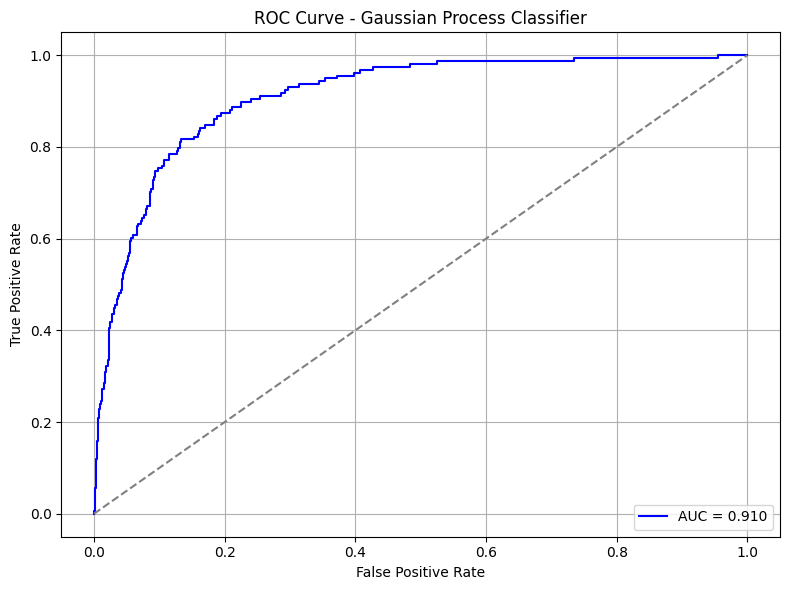

✅ AUC Score: 0.910


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
y_proba_c = gpc.predict_proba(X_test_c)[:, 1]

# Compute FPR, TPR, thresholds
fpr, tpr, thresholds = roc_curve(y_test_c, y_proba_c)

# Compute AUC
auc_score = roc_auc_score(y_test_c, y_proba_c)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gaussian Process Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print AUC Score
print(f"✅ AUC Score: {auc_score:.3f}")


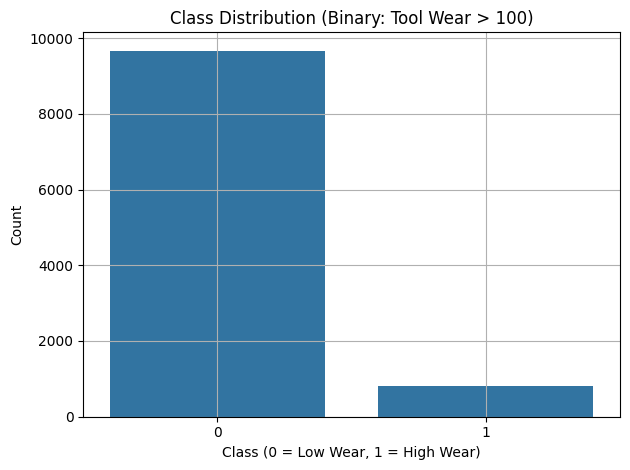

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot class distribution
sns.countplot(x=y_class)
plt.title("Class Distribution (Binary: Tool Wear > 100)")
plt.xlabel("Class (0 = Low Wear, 1 = High Wear)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


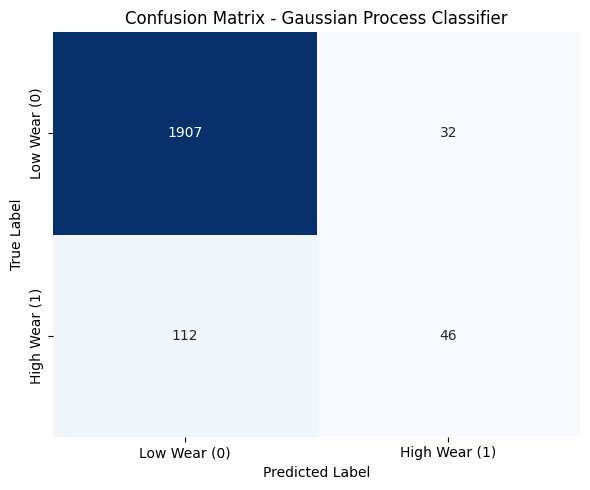

In [ ]:
from sklearn.metrics import confusion_matrix

# Predict using your GPC model
y_pred_c = gpc.predict(X_test_c)

# Create confusion matrix
cm = confusion_matrix(y_test_c, y_pred_c)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Gaussian Process Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ['Low Wear (0)', 'High Wear (1)'])
plt.yticks([0.5, 1.5], ['Low Wear (0)', 'High Wear (1)'])
plt.tight_layout()
plt.show()
